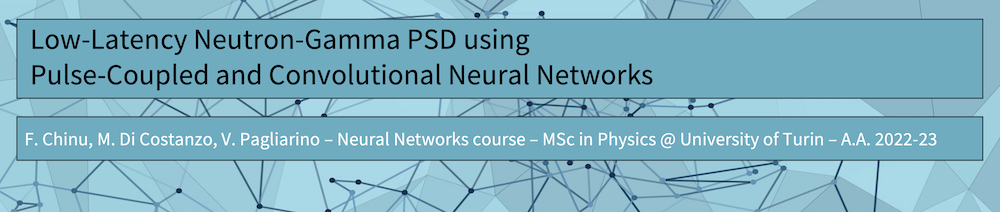

# Unsupervised 'Teacher' model based on PCNN
## Authors: Fabrizio Chinu, Marcello Di Costanzo, Valerio Pagliarino

### MSc. students in Physics - curriculum "Fisica Nucleare Subnucleare e Biomedica" - Università degli Studi di Torino 

#### Neural Networks course, prof. M. Osella - 2023

Pulse-Coupled Neural Networks (PCNN) are a class of neural network models inspired by the neurons in the brain trying to reproduce their timing behavior. In this first part of the project, we will use this algorithm to discriminate signals generated in scintillators coupled to SiPM by neutrons and $\gamma$s

In [1]:
#Standard imports
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import pandas as pd
import pickle

#Imports needed for splitting the dataset in training and test and for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#Imprts needed for plots
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sb

## PCNN Implementation

Here is the implementation of the PCNN: after setting the parameters that we adapted from the work by [Hao-Ran Liu et al](https://doi.org/10.1007/s41365-021-00915-w) and initializing the feeding and linking inputs, the internal activity, the threshold and the model output, the model is applied to the signals. For each input, the model iterates 180 times; at each iteration, the model updates using the following formulae:
<center>
$F_i[n] = e^{-\alpha_F}F_i[n-1] +V_F\sum\nolimits_{j} M_{ij}Y_j[n-1] +S_i$
</center>
<p>
<center>
$    L_i[n] = e^{-\alpha_L}L_i[n-1] +V_L\sum\nolimits_{j} M_{ij}Y_j[n-1]  $
</center>
<p>
<center>
$    U_i[n] = F_i[n]\left\{1+\beta L_i[n]\right\} $
</center>
<p>
<center>
$    Y_i[n] = \begin{cases}
     1 \ \mathrm{if}\ U_i[n] > T_i[n] \\
     0 \    \mathrm{otherwise}
    \end{cases} $
</center>
<p>
<center>
$    T_i[n] = e^{-\alpha_T}T_i[n-1] + V_T Y_i[n-1] $
</center>
<p>
The model output consists of the ignition map, i.e. a vector with the same dimensions as the signal, containing the number of ignitions of each neuron

In [2]:
def PCNN(data):
    S = data
    
    # Variables initialization
    W = np.array([0.1409, 0, 0.1409])
    Y = np.zeros(len(data))
    U = np.copy(Y)
    TS= np.copy(Y)
    E = np.copy(Y) + 1
    M = np.copy(W)
    F = np.copy(Y)
    L = np.copy(Y)
    U = np.copy(Y)
    E = np.copy(Y)
    
    # Parameters setting
    k = 180
    al=0.356
    vl=0.0005
    ve=15.5
    ae=0.08
    af=0.32
    vf=0.0005
    beta=0.4
    
    # PCNN Update
    for _ in range(k):
        F = np.exp(-af) *F +vf*np.convolve(Y,M,'same') + S;  
        L = np.exp(-al) *L +vl*np.convolve(Y,W,'same');              
        U = F*(1 + beta*L)    
        E = np.exp(-ae) * E + ve * Y
        Y = U > E
        TS =TS+Y
    return TS

Here we produce the value **R** on which we will label the signals by integrating the ignition map in the time interval $(\mathrm{\overline{P}}-7, \mathrm{\overline{P}}+123)$ ns, $\mathrm{\overline{P}}$ being the time when a pulse reaches its maximum value

In [3]:
def getPCNNr(raw_dataset_np, deltaLow = 7, deltaHigh = 123):
    Ignition_map=[]
    R_arr =[]
    for data in raw_dataset_np:
        Ignition_map.append(PCNN(data))    
        maxvalue,maxposition = np.amax(data), np.argmax(data) # Find the maximum position of a pulse signal
        m0 = maxposition-deltaLow
        SUM=np.sum(Ignition_map[-1][m0:maxposition+deltaHigh]) # Integrate the ignition map in the region of interest
        R_arr.append(SUM)
    return np.array(R_arr)

## Definition of the double gaussian function used to obtain the Figure of Merit (FoM)

In [4]:
def DoubleGauss(x, c1, c2, mu1, mu2, s1, s2):
    y = c1*np.exp(-1*(x-mu1)**2/(2*s1**2)) + c2*np.exp(-1*(x-mu2)**2/(2*s2**2))
    return y

## <center> **PCNN application to data** </center>

### PCNN - Validation on dataset 3

In order to validate the PCNN model discrimination capabilities, we can apply it on a labelled dataset

In [18]:
#Load the dataset

dataset_path_neutron_valid3 = "./dataset3/forML_neutron_LOOSE.txt"
raw_neutron_valid3 = pd.read_csv(dataset_path_neutron_valid3, sep=' ', header=None)
dataset_path_gamma_valid3 = "./dataset3/forML_gamma_LOOSE.txt"
raw_gamma_valid3 = pd.read_csv(dataset_path_gamma_valid3, sep=' ', header=None)

In [19]:
raw_gamma_valid3_np_src = raw_gamma_valid3.to_numpy().transpose()[:-1].transpose()
raw_neutron_valid3_np_src = raw_neutron_valid3.to_numpy().transpose()[:-1].transpose()
raw_gamma_valid3_np = normalize(raw_gamma_valid3_np_src)
raw_neutron_valid3_np = normalize(raw_neutron_valid3_np_src)

In [20]:
# Apply the model to the dataset and save its output
R_val3_gamma = getPCNNr(raw_gamma_valid3_np)
R_val3_neutron = getPCNNr(raw_neutron_valid3_np)
R_dict3 = {'raw_gamma' : raw_gamma_valid3_np, 'getPCNNr_gamma' : R_val3_gamma,
          'raw_neutron' : raw_neutron_valid3_np, 'getPCNNr_neutron' : R_val3_neutron}
with open('./arrays/dataset3_PCNN_Out_loose.p', 'wb') as handle:
    pickle.dump(R_dict3, handle, protocol=pickle.HIGHEST_PROTOCOL)

Here we look at the distributions of the PCNN outputs on the labelled dataset. We hope to find that the PCNN separates the two signals, thus we would like to see the gamma signals obtain lower **R**s with respect to the neutron signals

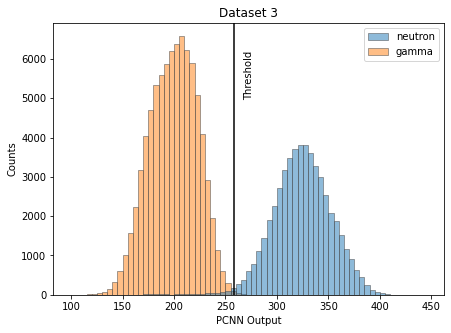

In [21]:
with open('./arrays/dataset3_PCNN_Out_loose.p', 'rb') as handle:
    R_val3 = pickle.load(handle)

R_val3_neutron = pd.DataFrame(R_val3['getPCNNr_neutron'], columns=['data'])
R_val3_gamma = pd.DataFrame(R_val3['getPCNNr_gamma'], columns=['data'])
R = pd.concat([R_val3_neutron.assign(particle='neutron'), R_val3_gamma.assign(particle='gamma')])

bins= np.arange(100,450,5)
#R_bins = np.digitize(R,bins)
f, ax = plt.subplots(figsize=(7, 5))
#sb.despine(f)

ax1 = sb.histplot(
    x=np.asarray(R['data'],'d'),
    hue=np.asarray(R['particle']),
    bins=bins,
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    legend = True
)

ax1.set(xlabel ="PCNN Output", ylabel = "Counts", title = "Dataset 3")

thr = 258 
plt.axvline(x=thr, c="black")
plt.text(thr*1.04, 5000, 'Threshold', rotation = "vertical");

This is exactly what we were looking for, now the PCNN model has been validated!

Once the model has been applied, we can study its output distribution. It reveals distinct peaks for the two types of signals, with neutrons exhibiting higher values and gammas displaying lower values of R. By setting a threshold value (258 for this dataset) it is possible to label as neutrons all the signals that score a PCNN output greater than the threshold, while the others are labelled as $\gamma$s

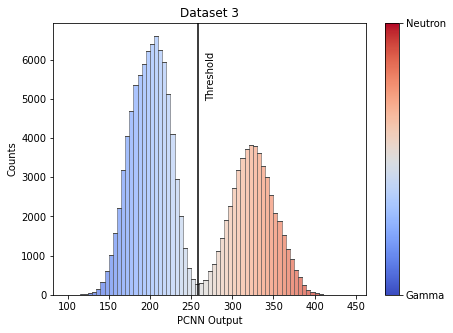

In [22]:
with open('./arrays/dataset3_PCNN_Out_loose.p', 'rb') as handle:
    R_val3 = pickle.load(handle)

R_val3_neutron = R_val3['getPCNNr_neutron']
R_val3_gamma = R_val3['getPCNNr_gamma']

R = np.concatenate((R_val3_neutron,R_val3_gamma))
    
bins= np.arange(100,450,5)
R_bins = np.digitize(R,bins)
f, ax = plt.subplots(figsize=(7, 5))
#sb.despine(f)

ax1 = sb.histplot(
    x=R, hue=R_bins,
    bins=bins,
    palette="coolwarm",
    edgecolor=".3",
    multiple='stack',
    linewidth=.5,
    log_scale=False,
    legend = False,
    cbar=True
)

ax1.set(xlabel ="PCNN Output", ylabel = "Counts", title = "Dataset 3")

cbar = plt.colorbar(mpl.image.AxesImage(ax1, cmap = "coolwarm"), orientation="vertical", ticks=[0, 1])
cbar.ax.set_yticklabels(['Gamma', 'Neutron'])

thr = 258 
plt.axvline(x=thr, c="black")
plt.text(thr*1.04, 5000, 'Threshold', rotation = "vertical");

In order to quantitatively describe the model performance, the following Figure of Merit (FoM) metric is used: 
$$\mathrm{FoM} = \frac{\mathrm{S}}{\mathrm{FWHM_n}+\mathrm{FWHM_\gamma}}\ ,$$
where S is the distance between the neutron and $\gamma$ peaks, while the FWHMs are the full width at half maximum of the distributions. In order to obtain all the ingredients needed to evaluate the $\mathrm{FoM-value}$, the output distribution is fitted with a double-gaussian distribution

In [23]:
# FoM-value calculation
hist, edges = np.histogram(R,bins,density=False)
means = []
for min,max in zip(edges[:-1],edges[1:]):
    means.append((min+max)/2)
means = np.array(means)
parameters, covariance = curve_fit(DoubleGauss, means, hist, p0=np.array([6500.,4000.,200.,330.,20.,10.]))

In [24]:
FOM = abs(parameters[2]-parameters[3])/(2.355*(parameters[4]+parameters[5]))
print(parameters) # Prints the fit parameters
print(FOM) # Prints the FoM-value

[6756.39119759 3826.01362227  200.39365367  324.90832299   24.98180515
   26.4092202 ]
1.0288269339816163


### PCNN - Dataset 1

In [5]:
#Load the dataset

dataset_path = "./dataset1/nomalizedDATA.txt"
raw_data = pd.read_csv(dataset_path, sep='\t', header=None)
raw_data_np = raw_data.to_numpy()
labels = np.zeros(len(raw_data_np))
raw_data

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0.017751,0.000000,0.011834,0.000000,0.011834,0.011834,0.017751,0.005917,0.011834,0.005917,...,0.029587,0.029587,0.041420,0.029587,0.029587,0.029587,0.029587,0.017751,0.029587,0.035504
1,0.011236,0.011236,0.005618,0.005618,0.011236,0.011236,0.000000,0.016854,0.011236,0.016854,...,0.022472,0.028091,0.039326,0.044944,0.039326,0.016854,0.022472,0.039326,0.033708,0.028091
2,0.011834,0.011834,0.011834,0.017751,0.005917,0.011834,0.017751,0.017751,0.011834,0.017751,...,0.029587,0.035504,0.029587,0.029587,0.035504,0.029587,0.047337,0.017751,0.029587,0.035504
3,0.018072,0.024096,0.018072,0.024096,0.024096,0.018072,0.024096,0.024096,0.012048,0.018072,...,0.024096,0.024096,0.030121,0.030121,0.048193,0.048193,0.042169,0.036146,0.036146,0.030121
4,0.022857,0.017143,0.017143,0.011429,0.011429,0.005714,0.011429,0.011429,0.011429,0.005714,...,0.028573,0.045714,0.040000,0.034286,0.040000,0.028573,0.040000,0.028573,0.028573,0.017143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9409,0.011905,0.017857,0.017857,0.011905,0.017857,0.005952,0.011905,0.017857,0.017857,0.011905,...,0.035715,0.029763,0.029763,0.035715,0.053571,0.017857,0.029763,0.023810,0.017857,0.023810
9410,0.005556,0.022222,0.000000,0.005556,0.000000,0.016667,0.016667,0.022222,0.011111,0.005556,...,0.044444,0.044444,0.044444,0.061111,0.044444,0.038889,0.033334,0.044444,0.033334,0.044444
9411,0.011561,0.017341,0.017341,0.028902,0.005780,0.011561,0.023121,0.017341,0.028902,0.005780,...,0.034683,0.034683,0.034683,0.046243,0.028902,0.040463,0.034683,0.034683,0.034683,0.034683
9412,0.011050,0.016575,0.022100,0.011050,0.011050,0.005525,0.016575,0.011050,0.011050,0.011050,...,0.027625,0.022100,0.033150,0.033150,0.033150,0.027625,0.027625,0.022100,0.033150,0.016575


In [6]:
# Apply the model to the dataset and save its output
R = getPCNNr(raw_data_np)
R_dict = {'raw' : raw_data_np, 'getPCNNr' : R}
with open('./arrays/dataset1_PCNN_Out.p', 'wb') as handle:
    pickle.dump(R_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Once the model has been applied, we can study its output distribution. It reveals distinct peaks for the two types of signals, with neutrons exhibiting higher values and gammas displaying lower values of R. By setting a threshold value (550 for this dataset) it is possible to label as neutrons all the signals that score a PCNN output greater than the threshold, while the others are labelled as $\gamma$s

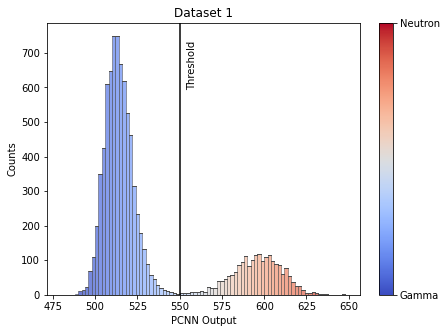

In [7]:
with open('./arrays/dataset1_PCNN_Out.p', 'rb') as handle:
    R = pickle.load(handle)['getPCNNr']

bins= np.arange(480,650,2)
R_bins = np.digitize(R,bins)
f, ax = plt.subplots(figsize=(7, 5))

ax1 = sb.histplot(
    x=R, hue=R_bins,
    bins=bins,
    palette="coolwarm",
    edgecolor=".3",
    multiple='stack',
    linewidth=.5,
    log_scale=False,
    legend = False,
    cbar=True
)

ax1.set(xlabel ="PCNN Output", ylabel = "Counts", title = "Dataset 1")

cbar = plt.colorbar(mpl.image.AxesImage(ax1, cmap = "coolwarm"), orientation="vertical", ticks=[0, 1])
cbar.ax.set_yticklabels(['Gamma', 'Neutron'])

thr = 550 
plt.axvline(x=thr, c="black")
plt.text(thr*1.008, 600, 'Threshold', rotation = "vertical");

In [8]:
# FoM-value calculation
hist, edges = np.histogram(R,bins,density=False)
means = []
for min,max in zip(edges[:-1],edges[1:]):
    means.append((min+max)/2)
means = np.array(means)
parameters, covariance = curve_fit(DoubleGauss, means, hist, p0=np.array([700.,100.,500.,600.,5.,10.]))

In [9]:
FOM = abs(parameters[2]-parameters[3])/(2.355*(parameters[4]+parameters[5]))
print(parameters) # Prints the fit parameters
print(FOM) # Prints the FoM-value

[735.97555162 113.29871504 513.00144666 596.58643233   7.8827041
  14.45156141]
1.5891529051174254


Once the PCNN model has been applied, we can save the labelled dataset to use it to train a student CNN model in a supervised learning environment

In [10]:
gammaDataset = []
neutronDataset = []

hiThreshold = 550
loThreshold = 550
for i in range(len(raw_data_np)):
    if (R[i] > hiThreshold):
        neutronDataset.append(raw_data_np[i])
    if (R[i] < loThreshold):
        gammaDataset.append(raw_data_np[i])
        
testset_dict = {'neutronDataset': np.array(neutronDataset), 'gammaDataset' : np.array(gammaDataset)}

with open('./arrays/testset.p', 'wb') as handle:
    pickle.dump(testset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### PCNN - Dataset 2

To study the flexibility of the PCNN and CNN models, they are applied to different datasets. While the PCNN doesn't need any training, the CNN model will be fine-tuned to achieve a good accuracy

In [11]:
#Load the dataset

dataset_path = "./dataset2/Neutron and gamma radiation pulse signal/raw signal/raw_signal.txt"
raw_data2 = pd.read_csv(dataset_path, sep=',', header=None)
raw_data2_np = raw_data.to_numpy()
labels = np.zeros(len(raw_data2_np))
raw_data2

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,-0.003448,0.002512,0.007635,0.030816,0.013975,0.020010,0.013381,0.023067,0.012883,0.003162,...,0.018821,0.014131,0.029144,0.028386,0.049418,0.036204,0.019318,0.017469,0.014672,0.029296
1,0.011111,0.016667,0.022222,0.016667,0.022222,0.005556,0.027778,0.016667,0.022222,0.022222,...,0.044445,0.033334,0.033334,0.027778,0.033334,0.038890,0.033334,0.027778,0.027778,0.033334
2,0.016483,0.016483,0.010989,0.016483,0.010989,0.005494,0.010989,0.016483,0.016483,0.016483,...,0.027473,0.043956,0.038462,0.038462,0.027473,0.027473,0.032968,0.021978,0.021978,0.027473
3,0.009697,0.009005,0.007409,0.004296,0.002463,0.027545,0.028268,0.005364,0.027674,0.005547,...,0.007989,0.024151,0.048966,0.013056,0.031486,0.032502,0.014270,0.020671,0.044331,0.026841
4,0.027790,0.021664,0.029899,0.007497,0.005309,0.003920,0.008046,-0.009681,0.009398,0.005593,...,0.021249,0.041713,0.036036,0.034182,0.033315,0.031363,0.055239,0.042832,0.042949,0.052585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14399,0.019988,0.009385,0.008966,0.016124,0.035787,-0.001818,0.009108,0.024167,0.004794,0.011491,...,0.023837,0.029565,0.036609,0.024418,0.048310,0.033331,0.033494,0.030550,0.029918,0.029036
14400,0.000000,0.011173,0.011173,0.005587,0.011173,0.011173,0.005587,0.011173,0.011173,0.005587,...,0.027934,0.033520,0.033520,0.044693,0.044693,0.022347,0.033520,0.027934,0.022347,0.016760
14401,0.024096,0.018072,0.012048,0.018072,0.018072,0.012048,0.018072,0.018072,0.030121,0.018072,...,0.030121,0.030121,0.024096,0.042169,0.036146,0.036146,0.036146,0.042169,0.036146,0.042169
14402,0.017964,0.017964,0.000000,0.011976,0.011976,0.017964,0.011976,0.011976,0.017964,0.017964,...,0.023952,0.035929,0.029941,0.035929,0.023952,0.029941,0.029941,0.035929,0.035929,0.029941


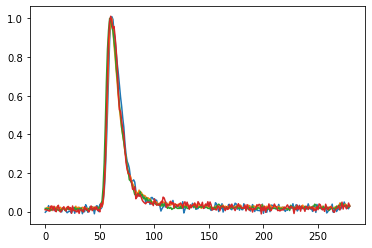

In [12]:
#Draw the first 4 signals

plt.plot(raw_data2.transpose()[0]);
plt.plot(raw_data2.transpose()[1]);
plt.plot(raw_data2.transpose()[2]);
plt.plot(raw_data2.transpose()[3]);

In [13]:
# Apply the model to the dataset and save its output
R = getPCNNr(raw_data2_np)
R_dict = {'raw' : raw_data2_np, 'getPCNNr' : R}
with open('./arrays/dataset2_PCNN_Out.p', 'wb') as handle:
    pickle.dump(R_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Once the model has been applied, we can study its output distribution. It reveals distinct peaks for the two types of signals, with neutrons exhibiting higher values and gammas displaying lower values of R. By setting a threshold value (550 for this dataset) it is possible to label as neutrons all the signals that score a PCNN output greater than the threshold, while the others are labelled as $\gamma$s

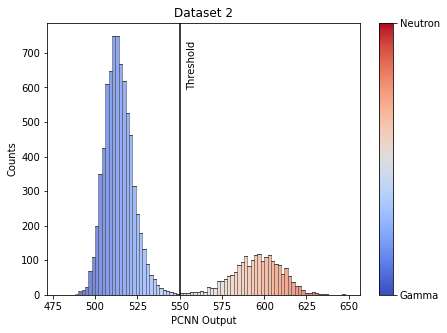

In [14]:
with open('./arrays/dataset2_PCNN_Out.p', 'rb') as handle:
    R = pickle.load(handle)['getPCNNr']

bins= np.arange(480,650,2)
R_bins = np.digitize(R,bins)
f, ax = plt.subplots(figsize=(7, 5))

ax1 = sb.histplot(
    x=R, hue=R_bins,
    bins=bins,
    palette="coolwarm",
    edgecolor=".3",
    multiple='stack',
    linewidth=.5,
    log_scale=False,
    legend = False,
    cbar=True
)

ax1.set(xlabel ="PCNN Output", ylabel = "Counts", title = "Dataset 2")

cbar = plt.colorbar(mpl.image.AxesImage(ax1, cmap = "coolwarm"), orientation="vertical", ticks=[0, 1])
cbar.ax.set_yticklabels(['Gamma', 'Neutron'])

thr = 550 
plt.axvline(x=thr, c="black")
plt.text(thr*1.008, 600, 'Threshold', rotation = "vertical");

In [15]:
# FoM-value calculation
hist, edges = np.histogram(R,bins,density=False)
means = []
for min,max in zip(edges[:-1],edges[1:]):
    means.append((min+max)/2)
means = np.array(means)
parameters, covariance = curve_fit(DoubleGauss, means, hist, p0=np.array([700.,100.,500.,600.,5.,10.]))

In [16]:
FOM = abs(parameters[2]-parameters[3])/(2.355*(parameters[4]+parameters[5]))
print(parameters) # Prints the fit parameters
print(FOM) # Prints the FoM-value

[735.97555162 113.29871504 513.00144666 596.58643233   7.8827041
  14.45156141]
1.5891529051174254


Once the PCNN model has been applied, we can save the labelled dataset to use it to train a student CNN model in a supervised learning environment

In [17]:
gammaDataset = []
neutronDataset = []

hiThreshold = 550
loThreshold = 550
for i in range(len(raw_data_np)):
    if (R[i] > hiThreshold):
        neutronDataset.append(raw_data_np[i])
    if (R[i] < loThreshold):
        gammaDataset.append(raw_data_np[i])
testset_dict = {'neutronDataset': np.array(neutronDataset), 'gammaDataset' : np.array(gammaDataset)}

with open('./arrays/Dataset2_Classified_PCNN.p', 'wb') as handle:
    pickle.dump(testset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)